In [25]:
import mxnet as mx
import numpy as np
import logging
import mnist

In [26]:
mnist.downloadmnist('data/mnist')

data/mnist/train-images-idx3-ubyte.gz already exists
data/mnist/train-labels-idx1-ubyte.gz already exists
data/mnist/t10k-images-idx3-ubyte.gz already exists
data/mnist/t10k-labels-idx1-ubyte.gz already exists


In [27]:
train_x, train_y, test_x, test_y = mnist.readmnist('data/mnist')

In [28]:
epochs = 10
batch_size = 100

In [29]:
train_iter = mx.io.NDArrayIter(data = train_x, label = train_y, batch_size = batch_size, shuffle = True)
test_iter = mx.io.NDArrayIter(data = test_x, label = test_y, batch_size = batch_size)

In [30]:
data = mx.sym.Variable("data")

In [31]:
fc1 = mx.sym.FullyConnected(data, name = 'fc1', num_hidden = 128)
relu1 = mx.sym.Activation(fc1, name = 'relu1', act_type = "relu")
fc2 = mx.sym.FullyConnected(relu1, name = "fc2", num_hidden = 64)
relu2 = mx.sym.Activation(fc2, name= "relu2", act_type = "relu")
fc3  = mx.sym.FullyConnected(relu2, name = 'fc3', num_hidden = 10)
out = mx.sym.SoftmaxOutput(fc3, name = "softmax")

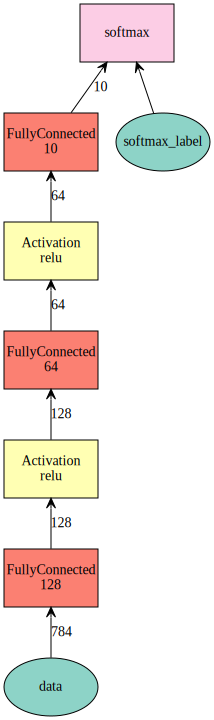

In [32]:
#We can visualize the entire layer by just giving it input size
temp_shape = {"data" : (batch_size, 784)}
mx.viz.plot_network(symbol = out, shape = temp_shape)

In [33]:
mod = mx.mod.Module(out)

In [34]:
print(mod.data_names)
print(mod.label_names)
print(train_iter.provide_data)
print(train_iter.provide_label)

['data']
['softmax_label']
[DataDesc[data,(100, 784),<class 'numpy.float32'>,NCHW]]
[DataDesc[softmax_label,(100, 10),<class 'numpy.float32'>,NCHW]]


In [35]:
mod.bind(data_shapes = train_iter.provide_data, label_shapes = train_iter.provide_label)

In [36]:
mod.init_params(initializer = mx.init.Xavier(magnitude = 2.))

In [37]:
mod.init_optimizer(optimizer = 'sgd', optimizer_params = (('learning_rate',0.01),))

In [38]:
mod.fit(train_iter, num_epoch = 50)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:488: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


In [39]:
'''
Alternative approach
mod.fit(train_iter,
        initializer = mx.initializer.Xavier(rnd_type = 'gaussian', factor_type 'avg', magnitude = 1.),
        optimizer = 'adam',
        optimizer_params= {'learning_rate':0.001},
        eval_metric = mx.metric.MSE(),
        num_epoch = epoch)
'''

"\nAlternative approach\nmod.fit(train_iter,\n        initializer = mx.initializer.Xavier(rnd_type = 'gaussian', factor_type 'avg', magnitude = 1.),\n        optimizer = 'adam',\n        optimizer_params= {'learning_rate':0.001},\n        eval_metric = mx.metric.MSE(),\n        num_epoch = epoch)\n"

In [40]:
mod.score(train_iter, ['mse','acc'])

[('mse', 0.0033490168801896896), ('accuracy', 0.900115)]

In [41]:
correct_preds = 0
for preds,i,batch in mod.iter_predict(test_iter):
    label = batch.label[0].asnumpy().argmax(axis = 1)
    pred_label = preds[0].asnumpy().argmax(axis = 1)
    correct_preds += np.sum(pred_label == label)
    #print("Batch Number:",i)
    #print("Correct labels",len(label))
    #print("Predicted labels",len(pred_label))
    #print("\n")

print("Test Set accuracy {%2.2f}" %(correct_preds/len(test_y)))

Test Set accuracy {0.97}


In [42]:
np.sum(pred_label == label)

96

In [43]:
#Another way to predict test data
test_iter = mx.io.NDArrayIter(test_x,test_y, batch_size)
acc = mx.metric.Accuracy()
mod.score(test_iter, acc)
print(acc)

EvalMetric: {'accuracy': 0.90022999999999997}


In [44]:
print(label)
print("\n",pred_label)

[8 9 0 1 2 3 4 5 6 7 8 0 1 2 3 4 7 8 9 7 8 6 4 1 9 3 8 4 4 7 0 1 9 2 8 7 8
 2 6 0 6 5 3 3 3 9 1 4 0 6 1 0 0 6 2 1 1 7 7 8 4 6 0 7 0 3 6 8 7 1 5 2 4 9
 4 3 6 4 1 7 2 6 5 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]

 [8 9 0 1 0 3 4 5 6 7 8 0 1 2 3 4 7 8 9 7 8 6 4 1 9 3 8 4 4 7 0 1 9 2 8 7 8
 2 6 0 6 5 3 3 8 9 1 4 0 6 1 0 0 6 2 1 1 7 7 8 4 6 0 7 0 3 6 8 7 1 5 2 4 9
 4 3 6 4 1 7 3 6 3 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]


In [22]:
test_iter.provide_label

[DataDesc[softmax_label,(100, 10),<class 'numpy.float32'>,NCHW]]

Reference:
    https://github.com/apache/incubator-mxnet/blob/master/example/module/mnist_mlp.py